# Pulsar data cube manipulation examples and code snippets

**Introduction**

This notebook is intended to give a general flavour of the format of pulsar candidate data and the types of processing that may be used during candidate analysis.

In overview this notbook will cover:
 - Generation of a fake data containing a "top-hat" pulse.
 - Integration of that data to provide useful views
 - Filtering of data to boost S/N measurement
 - Manipulation of the data to tweak parameters of period and dispersion measure (DM)

**Generating fake data**

Below we generate a synthetic data cube that is representative of real-world observational data under ideal conditions. The data generated here is a cube with dimensions phase, time and frequency. The parameters of the cube are determined by the following metadata:

In [82]:
metadata = {
    "period": 0.01, # period in seconds.
    "acceleration": 0.0, # acceleration in m/s/s.
    "dm": 34.1, # dispersion measure in units of parsecs per centimetre cubed (pc/cc).
    "tobs": 600.0, # the duration in seconds of the observation in which the data was taken.
    "cfreq": 1400.0, # the centre frequency of the observation in MHz.
    "bw": 300.0, # the bandwidth of the observation in MHz. 
    "nsubint": 64, # the number of bins in the time axis.
    "nsubband": 32, # the number of bins in the frequency axis.
    "nphase": 128, # the number of bins across the pulsar profile.
    "dc": 0.1 # the duty-cycle of the pulse (fraction of a spin for which the pulse is on).
}

# the following parameters are also derived for convenience:
metadata["chbw"] = metadata["bw"]/metadata["nsubband"] # the width in MHz of each frequency channel.
metadata["tsub"] = metadata["tobs"]/metadata["nsubint"] # the width in seconds of each temporal bin.
metadata["tphase"] = metadata["period"]/metadata["nphase"] # the width of each bin across the profile in seconds.

Here we generate the cube based on the above metadata. We will initially populate the cube with normally distributed noise with a mean of 0 and unity variance. The dimensions of the cube are (slowest to fastest changing) frequency, time and phase.

In [83]:
import numpy as np

def generate_fake_data(metadata):
    x = metadata["nsubint"]
    y = metadata["nsubband"]
    z = metadata["nphase"]
    cube = np.random.normal(0,1,[x,y,z])
    return cube

**Injecting a pulsar-like signal**

To make this data more realistic we will inject a pulsar-like signal into it. For simplicity we will assume a top-hat pulse. Pulsars show a wide variety of pulse shapes and so there is no strong reason to attempt to generate a more reaslistic signal.

In [84]:
def generate_fake_signal(metadata, power):
    profile = np.zeros([metadata["nphase"]])
    pulse_width = int(max(1,metadata["nphase"]*metadata["dc"]))
    start_bin = metadata["nphase"]//2 - pulse_width//2
    profile[start_bin:start_bin+pulse_width] = power
    return profile

def inject_signal(data,signal):
    assert signal.size == data.shape[-1], "profile length must match inner data dimension"
    data += signal
    return data

test_data = generate_fake_data(metadata)
test_profile = generate_fake_signal(metadata,0.2)
data = inject_signal(test_data,test_profile)

**Visualising the cube**

Here it is worth taking a quick look at what we have produced. To do this we decompose the data into 4 views, time-phase, frequency-phase, time-frequency and pulse profile (e.g. power vs spin phase). These are typical views that are used during the visual analysis of pulsar candidates.

In [85]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

**Time vs. phase view**

This view used to evaluate if the signal is persistent in time (i.e. a continuous source). Below we see a faint column of signal. The column is vertical, implying that the period that the data was folded with is the same as the period of the signal of interest. If the there were a significant slope in this column of signal, this would be an indication that the folding period of the data is not quite the same as that of the signal of interest.

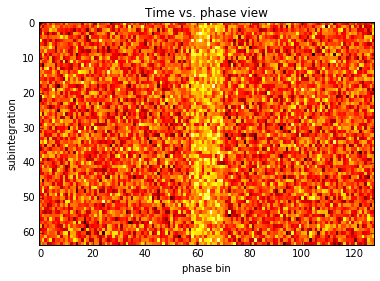

In [86]:
time_phase_view = data.sum(axis=1)
plt.imshow(time_phase_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.xlabel("phase bin")
plt.ylabel("subintegration")
plt.title("Time vs. phase view")

**Frequency vs. phase view**

This view is used to evaluate that the signal is broadband (i.e. the signal can be seen across most or even all of the observing bandwidth). As above the column of signal here is vertical. If we were to see a quadratic curve in this signal, this would imply that the data had not been dedispersed to the optimal dispersion measure.

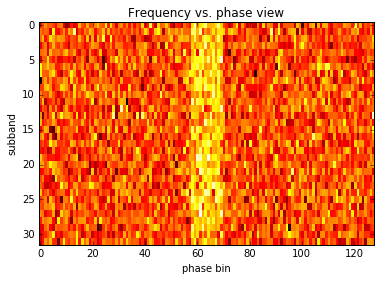

In [87]:
freq_phase_view = data.sum(axis=0)
plt.imshow(freq_phase_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.xlabel("phase bin")
plt.ylabel("subband")
plt.title("Frequency vs. phase view")

**Time vs. frequency view**

This view is predominantly used to determine that the overall level of signal is stable across all frequencies for the duration of an observation. If there are bright spikes in this view, it is often indicative of a burst of radio frequency interference polluting our observation.

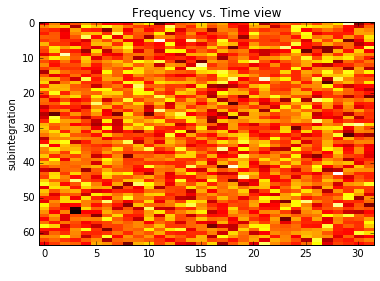

In [88]:
freq_time_view = data.sum(axis=2)
plt.imshow(freq_time_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.ylabel("subintegration")
plt.xlabel("subband")
plt.title("Frequency vs. Time view")

**Pulse profile view**

This view is used to see the shape of the pulse profile of the signal. This is often useful in determining whether the signal is man-made. Most often, it is this view that is used to determine the statistical significance of the signal. 

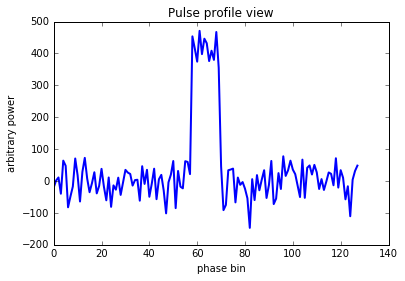

In [89]:
profile_view = data.sum(axis=0).sum(axis=0)
plt.plot(profile_view,lw=2)
plt.ylabel("arbitrary power")
plt.xlabel("phase bin")
plt.title("Pulse profile view")

**Matched filtering**

A typical processing step that is done to such cubes is to apply a matched filter to determine a measure of the width of the pulse (this is typically an a priori unknown). This is often done in the Fourier domain so that complex pulse shapes can be supported. However, here we know we have a top-hat pulse and as such we will use a simple nearest neighbour addition to filter the data. The aim here is to recover the pulse width from the data alone.

Best width value is 12 bins
Expected result is 12 bins
Pulse is centred on bin 69


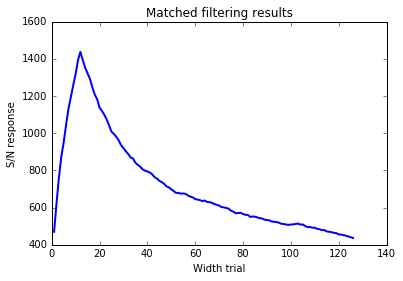

In [90]:
# This funtion applies a matched filter of size "width" to
# the an array along a given axis.
def matched_filter(array,width,axis=0):
    assert width >=1, "width must be >= 1"
    filtered_array = np.zeros_like(array)
    for offset in range(width):
        filtered_array += np.roll(array,offset,axis)
    return filtered_array / np.sqrt(width)
   
    
# This function performs a brute-force trialing of various
# possible widths for the filter. The best matching filter
# should result in the highest S/N response.
def find_pulse_width(profile):
    widths = np.arange(1,profile_view.size-1)
    snrs = np.zeros_like(widths)
    bins = np.zeros_like(widths)
    for ii,width in enumerate(widths):
        filtered = matched_filter(profile,width)
        snrs[ii] = filtered.max()
        bins[ii] = filtered.argmax()
    best_width = widths[snrs.argmax()]
    best_phase = bins[snrs.argmax()]
    return best_width,best_phase,widths,snrs

best_width, best_phase, width_trials, snr_values = find_pulse_width(profile_view)
print("Best width value is %d bins"%(best_width))
print("Expected result is %d bins"%(int(max(1,metadata["nphase"]*metadata["dc"]))))
print("Pulse is centred on bin %d"%best_phase)

plt.plot(width_trials,snr_values,lw=2)
plt.xlabel("Width trial")
plt.ylabel("S/N response")
plt.title("Matched filtering results")

**Applying filter to views**

For certain applications it is useful to apply our best filter to the frequency-phase and time-phase views to make the signal clearer to the human observer. Generating filtered versions of these views also allows us to easier investigate the persistence of the signals in time and frequency.

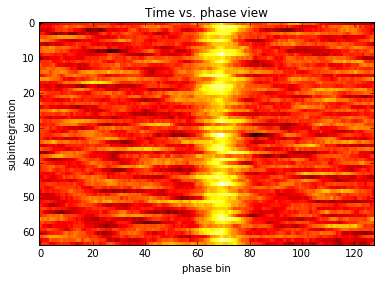

In [91]:
filtered_tp_view = matched_filter(time_phase_view,best_width,axis=1)
plt.imshow(filtered_tp_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.xlabel("phase bin")
plt.ylabel("subintegration")
plt.title("Time vs. phase view")

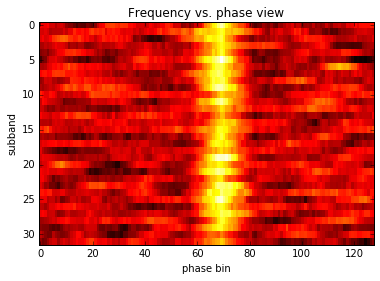

In [92]:
filtered_fp_view = matched_filter(freq_phase_view,best_width,axis=1)
plt.imshow(filtered_fp_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.xlabel("phase bin")
plt.ylabel("subband")
plt.title("Frequency vs. phase view")

**Time and frequency persistence**

We know from the physical properties of pulsars that their observed signals should exhibit two clear features: Persistence in time and broadbandedness. To generate an estimate of these two properties, we can use the filters generted in the previous steps and assess whether or not the maxumum value of each subband or subintegration falls in the expected phase window of the pulse (as determined by the "find_pulse_width" function).

In [93]:
def find_persistence(phase_array,best_width,best_phase):
    assert len(phase_array.shape) == 2, "phase_array must be 2D"
    # find the maximum bin of each subintegration or subband
    phase_maxima = phase_array.argmax(axis=1)
    half_width = best_width//2
    # find maximum bins that lie in the expected phase window
    mask = ((phase_maxima > (best_phase-half_width)) & (phase_maxima < (best_phase+half_width)))
    # find fraction of bins in the phase window
    persistence = mask.sum()/float(phase_array.shape[0])
    return persistence

time_persistence = find_persistence(filtered_tp_view,best_width,best_phase)
print("Fractional persistence in the time domain is %0.2f per cent"%(time_persistence*100))
frequency_persistence = find_persistence(filtered_fp_view,best_width,best_phase)
print("Fractional persistence in the time domain is %0.2f per cent"%(frequency_persistence*100))

Fractional persistence in the time domain is 95.31 per cent
Fractional persistence in the time domain is 100.00 per cent


**Updating dispersion measure**

Often it is neccessary to tweak some parameters of the folded data cubes to optimise for a given signal. One parameter that can be optimised over is that of dispersion measure. Frequency dispersion causes signals at differnent frequecies to travel through the interstellar medium (the cold ionised plasma of space) at different rates, with signals at lower frequency travelling slower than those at higher frequency. The delay in seconds between two signals at different frequencies is given by

$\delta \tau = 4.15\times10^3 \left( \frac{1}{f_0^2} - \frac{1}{f_1^2} \right) \rm{DM},$

where $f_0$ and $f_1$ are the two frequencies (the convention is that $f_0$ is the lower frequency of the two). By determining this delay for a given dispersion measure offset (called "delta_dm" in the function below), we can work out the number of phase bins we need to rotate the inner two dimensions of the data cube by for each frequency (where frequency is the outer dimension).

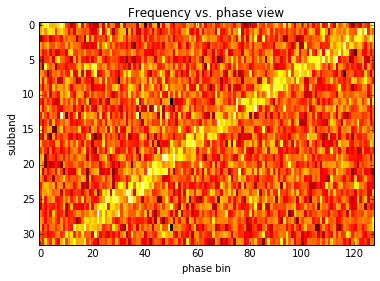

In [94]:
# assumes that lower subband number corresponds to lower frequency

# This function generates a new version of the original data cube
# by rotating each subband by the delay that corresponds to its
# frequency.
def update_dispersion_measure(data,delta_dm,metadata):
    # Determine the frequency spread across the band
    fbottom = metadata["cfreq"] - metadata["bw"]/2
    ftop =  metadata["cfreq"] + metadata["bw"]/2
    # Determine the frequency of each subband
    frequencies = np.linspace(fbottom,ftop,metadata["nsubband"])
    # Determine the delay in seconds and in phase bins
    delay_seconds = 4.15e3 * (1/frequencies**2 - 1/metadata["cfreq"]**2) * delta_dm
    delay_bins = (delay_seconds//metadata["tphase"]).astype("int32")
    # For each channel rotate the inner dimensions of the cube and 
    # write this into a new array
    dedispersed_data = np.empty_like(data)
    for chan,freq in enumerate(frequencies):
        dedispersed_data[:,chan,:] = np.roll(data[:,chan,:],delay_bins[chan],axis=1)
    return dedispersed_data

dedispersed_data = update_dispersion_measure(data,10.0,metadata)
new_freq_phase_view = dedispersed_data.sum(axis=0)
plt.imshow(new_freq_phase_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.xlabel("phase bin")
plt.ylabel("subband")
plt.title("Frequency vs. phase view")

**Optimising dispersion measure**

As we now know both the expected width of the signal and have a method of tweaking the DM. It is possible to trial multiple DM values to determine the best one. Normally it would be also necessary to assess the best pulse width for each trial DM, but for the sake of brevity we shall exclude that operation here.

Below we apply our matched filter to the original data cube before searching around a series of DM offsets around the current DM of the folded cube. Note that we expect the best offset to be zero here as we generated our fake data under the assumption that its DM was perfectly known. For real data this will not be the case.

[Note: For optimisations of width and DM it is also possible/preferable to use more standard minimisation/optimisation tools such as scipy.optimise.]

Best DM offset is -0.10 pc/cc


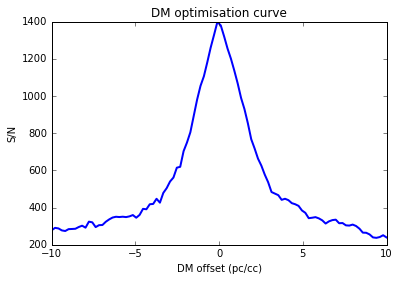

In [96]:
filtered_cube = matched_filter(data,best_width,axis=2)

def optimize_dm(cube,low_dm,high_dm,steps,metadata):
    trial_dms = np.linspace(low_dm,high_dm,steps)
    snrs = np.zeros_like(trial_dms)
    for ii,dm in enumerate(trial_dms):
        snrs[ii] = update_dispersion_measure(cube,dm,metadata).sum(axis=0).sum(axis=0).max()
    return trial_dms[snrs.argmax()],trial_dms,snrs

best_dm_offset,trial_dms,snrs = optimize_dm(filtered_cube,-10,10,100,metadata)
print("Best DM offset is %0.2f pc/cc"%best_dm_offset)

plt.plot(trial_dms,snrs,lw=2)
plt.xlabel("DM offset (pc/cc)")
plt.ylabel("S/N")
plt.title("DM optimisation curve")

**Updating period**

Just as with updating and optimising DM it is also possible to update and optimise the period of the signal in the folded data cube. We shall refer to the folding period of the data cube as $P_{\rm cube}$ and the true period of the signal as $P_{\rm signal}$. When these differ, it causes the signal to drift in phase over the course of an observation. This drift is given by the expression

$\delta\phi = \frac{t_{\rm obs}}{P_{\rm cube}} \left(\frac{P_{\rm signal}}{P_{\rm cube}} -1 \right),$

where $t_{\rm obs}$ is the observation duration (all periods and durations are in seconds). By determining the expected phase drift, we can correct for it by rotating the phase axis of our data cube for each subintegration. For simplicity we will do this via transpose.

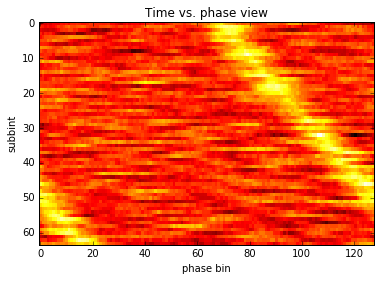

In [97]:
def update_period(data,delta_period,metadata):
    old_p = metadata["period"]
    new_p = old_p + delta_period
    nsubint = metadata["nsubint"]
    delta_phase = (metadata["tobs"]/old_p) * (new_p/old_p - 1)
    phase_delays = ((np.arange(nsubint) * delta_phase * metadata["nphase"])//nsubint).astype("int32")
    new_data = np.empty_like(data)
    for ii,delay in enumerate(phase_delays):
        new_data[ii] = np.roll(data[ii],delay,axis=1)    
    return new_data

refolded_data = update_period(filtered_cube,1e-7,metadata)
new_time_phase_view = refolded_data.sum(axis=1)
plt.imshow(new_time_phase_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.xlabel("phase bin")
plt.ylabel("subbint")
plt.title("Time vs. phase view")

**Optimising period**

Following the same brute-force trialing method we used to optimise DM, we can also optimise period. Again as with the DM optimisation, the use of fake data here means that the period offset should always optimise to be approximately 0 seconds. This will not be the case with real data.

Best period offset is 1.001001e-10 seconds


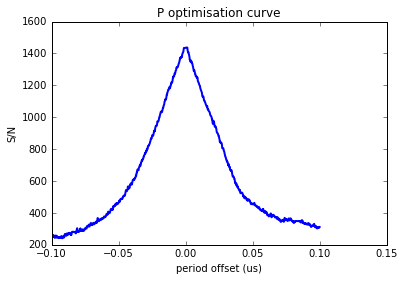

In [98]:
def optimize_p(cube,low_p,high_p,steps,metadata):
    trial_p = np.linspace(low_p,high_p,steps)
    snrs = np.zeros_like(trial_p)
    for ii,p in enumerate(trial_p):
        snrs[ii] = update_period(cube,p,metadata).sum(axis=0).sum(axis=0).max()
    return trial_p[snrs.argmax()],trial_p,snrs

best_p_offset,trial_p,snrs = optimize_p(filtered_cube,-1e-7,1e-7,1000,metadata)
print("Best period offset is %e seconds"%best_p_offset)

plt.plot(trial_p/1e-6,snrs,lw=2)
plt.xlabel("period offset (us)")
plt.ylabel("S/N")
plt.title("P optimisation curve")

**Optimisation notes**

Typically when we optimse period, we also need to optimise DM. As we do not know the pulse width a priori, we also need to optimise that. By brute-force methods this can be quite taxing as it requires the folded data cube to be reconfigured and collapsed n_dm_trials * n_period_trials * n_width_trials times. This is made more difficult when we want to also optimise for acceleration and potentailly its higher order terms (snap, crackle and pop).

**Loading real data**

For ease of use we provide real pulsar observations in a simplified python pickle format. These data are publicly available through the CSIRO Data Access Portal (https://data.csiro.au/dap/landingpage?execution=e4s2).

To load an observation simply use:

```
# python 2.x
import cPickle
with open("<filename>","r") as f:
    info = cPickle.load(f)
```

This will return a python dictionary with metadata as defined above and an extra parameter containing the data in numpy array format. For example loading file p131023_054056.pickle should result in the following:

```
{'source': "J1708-3506"
 'acceleration': 0.0,
 'bw': 400.0,
 'cfreq': 1382.0,
 'chbw': 0.78125,
 'data': array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.03136735,  0.03081939,  0.0309536 , ...,  0.03076749,
            0.03073598,  0.03079557],
          [ 0.0313917 ,  0.03150747,  0.03133942, ...,  0.03150104,
            0.03146186,  0.03158342],
          ..., 
          [ 0.03337697,  0.03357352,  0.03353807, ...,  0.03351316,
            0.0336275 ,  0.03309928],
          [ 0.03373688,  0.03329305,  0.03364284, ...,  0.03344358,
            0.03329661,  0.03375616],
          [ 0.03573179,  0.03570115,  0.03542275, ...,  0.03532366,
            0.0358793 ,  0.03538065]]],
 
        
 
        [[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.03192095,  0.03268269,  0.0324588 , ...,  0.03225028,
            0.03149604,  0.03219886],
          [ 0.03281545,  0.03301142,  0.03311156, ...,  0.03228668,
            0.03288195,  0.03223149],
          ..., 
          [ 0.03468782,  0.03462947,  0.03467603, ...,  0.03463778,
            0.03502815,  0.03500563],
          [ 0.03508489,  0.03516412,  0.03515525, ...,  0.03481415,
            0.03523044,  0.03501428],
          [ 0.03740999,  0.03722799,  0.03673326, ...,  0.03781848,
            0.03646157,  0.03720494]]]], dtype=float32),
 'dc': 0.1,
 'dm': 146.752990722656,
 'nphase': 1024,
 'nsubband': 512,
 'nsubint': 35,
 'period': 0.004505158948381383,
 'tobs': 839.7785088000007,
 'tphase': 4.399569285528695e-06,
 'tsub': 23.99367168000002}
```
 
Note: The 'dc' and 'acceleration' parameters have been left with default parameters as these must be determined from the data (unlike in the fake data generation where they are inputs).

**Real data**

There are 6 observations for testing purposes:
    
    p131023_054056.pickle	
    p131201_193752.pickle	
    p131202_005704.pickle	
    p140129_175200.pickle	
    s131215_213427.pickle	
    s140129_175147.pickle
    
Each contains a detection of a pulsar, but each has a different pulse profile (pulse shape) and brightness.

Below we apply some of the operations described above to real observation.

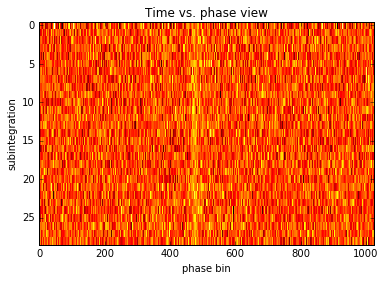

In [106]:
import cPickle

with open("data/p131201_193752.pickle","r") as f:
    metadata = cPickle.load(f)

data = metadata["data"]    

time_phase_view = data.sum(axis=1)
plt.imshow(time_phase_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.xlabel("phase bin")
plt.ylabel("subintegration")
plt.title("Time vs. phase view")

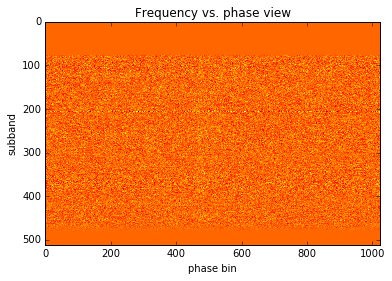

In [107]:
freq_phase_view = data.sum(axis=0)
plt.imshow(freq_phase_view,aspect="auto",interpolation="nearest",cmap="hot")
plt.xlabel("phase bin")
plt.ylabel("subband")
plt.title("Frequency vs. phase view")

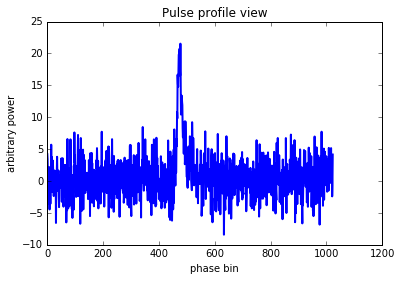

In [109]:
profile_view = data.sum(axis=0).sum(axis=0)
plt.plot(profile_view,lw=2)
plt.ylabel("arbitrary power")
plt.xlabel("phase bin")
plt.title("Pulse profile view")

In [113]:
best_width, best_phase, width_trials, snr_values = find_pulse_width(profile_view)
filtered_cube = matched_filter(data,best_width,axis=2)

Best DM offset is -0.10 pc/cc


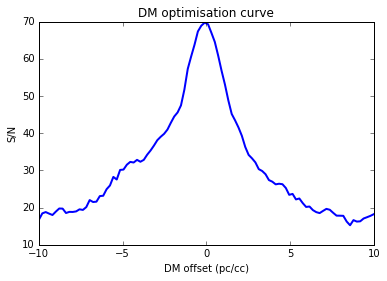

In [114]:
best_dm_offset,trial_dms,snrs = optimize_dm(filtered_cube,-10,10,100,metadata)
print("Best DM offset is %0.2f pc/cc"%best_dm_offset)

plt.plot(trial_dms,snrs,lw=2)
plt.xlabel("DM offset (pc/cc)")
plt.ylabel("S/N")
plt.title("DM optimisation curve")

Best period offset is 2.902903e-09 seconds


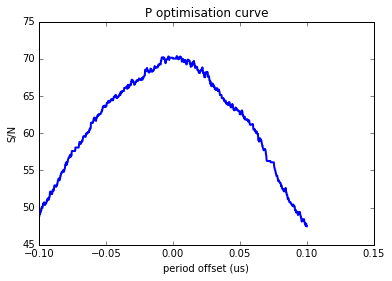

In [115]:
best_p_offset,trial_p,snrs = optimize_p(filtered_cube,-1e-7,1e-7,1000,metadata)
print("Best period offset is %e seconds"%best_p_offset)

plt.plot(trial_p/1e-6,snrs,lw=2)
plt.xlabel("period offset (us)")
plt.ylabel("S/N")
plt.title("P optimisation curve")